In [3]:
import numpy as np
import networkx as nx
import os, time

import os.path as osp
import glob
from wmpgnn.datasets.graph_dataset import CustomDataset
from wmpgnn.datasets.hetero_graph_dataset import CustomHeteroDataset
from torch_geometric.loader import DataLoader
import contextlib
import torch
from torch import nn
from torch_scatter import scatter_add
from wmpgnn.configs.config_loader import ConfigLoader
from wmpgnn.datasets.data_handler import DataHandler
from wmpgnn.model.model_loader import ModelLoader
from torch_geometric.nn.models import MLP
from torch.nn import ReLU

In [2]:
from wmpgnn.configs.config_loader import ConfigLoader
# Load the configuration
config_loader = ConfigLoader("config_files/heteromp_gnn.yaml", environment_prefix="DL")

In [3]:
print(f"Loading Dataset {config_loader.get('dataset')}")

Loading Dataset {'data_type': 'heterogeneous', 'data_dir': '/media/sutclw/WILLSSD/truth_inclusive_10k_49193'}


In [4]:
print(f"Loading Dataset {config_loader.get('dataset.data_type')}")
data_loader = DataHandler(config_loader)
data_loader.load_data()


Loading Dataset heterogeneous


In [5]:
def mlp(output_size):
    return lambda: MLP(in_channels=-1, hidden_channels=128,  # Increased size
                       out_channels=output_size, num_layers=6, norm='batch_norm', act=ReLU())  

NN =mlp(1)()


NN.load_state_dict(torch.load('MLP_pvs.pt', weights_only=True))
NN.eval()
NN.cuda()

MLP(-1, 128, 128, 128, 128, 128, 1)

In [27]:
from wmpgnn.configs.config_loader import ConfigLoader
# Load the configuration
config_loader = ConfigLoader("config_files/heteromp_gnn.yaml", environment_prefix="DL")

In [28]:
model_loader = ModelLoader(config_loader)
model = model_loader.get_model()

In [29]:
#model.load_state_dict(torch.load("/media/sutclw/WILLSSD/bn_trainings_new/Final_full_graph_hetero_8block_36_epochs_message_passing_BCE_batch_norm_4mlp_layers.pt"))
#model.load_state_dict(torch.load("/media/sutclw/WILLSSD/bn_trainings_new/Final_full_graph_hetero_8block_10_pv_task_with_track_edges.pt"))
model.load_state_dict(torch.load("/media/sutclw/WILLSSD/bn_trainings_new/Final_full_graph_hetero_8block_10_pv_task.pt"))
model.eval()
model.cuda()

/tmp/ipykernel_14994/1134652269.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/media/sutclw/WILLSSD/bn_trainings_new/Final_full_graph

HeteroGNN(
  (_encoder): HeteroGraphCoder(
    (_global_model): WrappedModelFnModule(
      (_model): MLP(-1, 128, 128, 128, 16)
    )
    (_edge_models_model_dict): ModuleDict(
      (('tracks', 'to', 'pvs')): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
    )
    (_node_models_model_dict): ModuleDict(
      (tracks): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (pvs): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
    )
  )
  (_blocks): ModuleList(
    (0-7): 8 x HeteroGraphNetwork(
      (_edge_block): HeteroEdgeBlock(
        (_edge_models_model_dict): ModuleDict(
          (('tracks', 'to', 'pvs')): MLP(-1, 128, 128, 128, 16)
        )
      )
      (_node_block): HeteroNodeBlock(
        (_received_edges_aggregator): HeteroEdgesToNodesAggregator()
        (_sent_edges_aggregator): HeteroEdgesToNodesAggregator()
        (_node_models_model_dict): ModuleDict(
          (tracks): MLP(-1, 12

In [30]:
# num_params = sum(p.numel() for p in model.parameters())
# print(f"Total number of parameters: {num_params}")
val_loader = data_loader.get_test_dataloader(batch_size=1)

In [31]:
running_acc = 0
running_num = 0
running_denom = 0
npvs = []
associated = []
b_track = []
event_no = []
n_tracks = []
b_tracks=False

model_type = "GNN"

for j, data in enumerate(val_loader):
    data.to('cuda')
    X=torch.concat([data['tracks'].x[data[('tracks','to','pvs')].edge_index[0]],
                    data['pvs'].x[data[('tracks','to','pvs')].edge_index[1]],
                    data[('tracks','to','pvs')].edges], -1)
    if model_type == "NN":
        outputs = NN(X)
    if model_type == "GNN":
        gnn_outputs = model(data)
    if model_type == "MINIP":
        outputs = outputs = data[('tracks','to','pvs')].edges
    PVlabel = torch.tensor(data[('tracks', 'to', 'pvs')].y, dtype=torch.float32)

    if b_tracks:
        tracks = data[('tracks', 'to', 'tracks')].edge_index[0][data[('tracks', 'to', 'tracks')].y[:, 0] == 0]
    else:
        tracks = data[('tracks', 'to', 'tracks')].edge_index[0]

    btracks = data[('tracks', 'to', 'tracks')].edge_index[0][data[('tracks', 'to', 'tracks')].y[:, 0] == 0]
    b_unique_tracks = torch.unique(btracks)
    unique_tracks = torch.unique(tracks)
    correctly_associated = 0
    
    for i in unique_tracks:
        index = (data[('tracks', 'to', 'pvs')].edge_index[0] == i)

        if model_type == "MINIP":
            pv_associated = (torch.argmin(
                outputs[index]) == torch.argmax(
                data[('tracks', 'to', 'pvs')].y[index]))
        elif model_type == "NN":
            pv_associated = (torch.argmax(
                outputs[index]) == torch.argmax(
                data[('tracks', 'to', 'pvs')].y[index]))
        elif model_type == "GNN":
            pv_associated = (torch.argmax(
            model._blocks[-1].edge_weights[('tracks', 'to', 'pvs')][index]) == torch.argmax(
            data[('tracks', 'to', 'pvs')].y[index]))
            
        correctly_associated += int(pv_associated.item())
        npvs.append(data['pvs'].x.shape[0])
        associated.append( int(pv_associated.item()))
        if i in b_unique_tracks:
            b_track.append(1)
        else:
            b_track.append(0)       
        event_no.append(j)
        n_tracks.append(unique_tracks.shape[0])
            
    # if unique_tracks.shape[0] > 0:
    #     npvs.append(data['pvs'].x.shape[0])
    #     associated.append( correctly_associated/ unique_tracks.shape[0])
    running_num += correctly_associated 
    running_denom += unique_tracks.shape[0]
acc = running_num / running_denom

/tmp/ipykernel_14994/1459700391.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PVlabel = torch.tensor(data[('tracks', 'to', 'pvs')].y, dtype=torch.float32)


In [10]:
acc

0.9982357815261022

In [13]:
import pandas

In [83]:
df_nn = pandas.DataFrame( data={'associated':associated, 'npvs':npvs, 'btrack' : b_track, 'event_number':event_no,
                       'n_tracks': n_tracks})

In [81]:
df_gnn = pandas.DataFrame( data={'associated':associated, 'npvs':npvs, 'btrack' : b_track, 'event_number':event_no,
                       'n_tracks': n_tracks})

In [105]:
df_minip = pandas.DataFrame( data={'associated':associated, 'npvs':npvs, 'btrack' : b_track, 'event_number':event_no,
                       'n_tracks': n_tracks})

In [14]:
df_gnn2 = pandas.DataFrame( data={'associated':associated, 'npvs':npvs, 'btrack' : b_track, 'event_number':event_no,
                       'n_tracks': n_tracks})

In [32]:
df_gnn3 = pandas.DataFrame( data={'associated':associated, 'npvs':npvs, 'btrack' : b_track, 'event_number':event_no,
                       'n_tracks': n_tracks})

In [15]:
df.npvs

0          6
1          6
2          6
3          6
4          6
          ..
1410818    8
1410819    8
1410820    8
1410821    8
1410822    8
Name: npvs, Length: 1410823, dtype: int64

In [11]:
np.mean(df.associated)

NameError: name 'df' is not defined

In [ ]:
!ls PV_association_HGNN_all_tasks.csv

In [33]:
df_gnn2.to_csv("PV_association_HGNN_no_track_edges.csv")

In [34]:
df_gnn3.to_csv("PV_association_HGNN_no_track_edges.csv")

In [22]:
bins = np.array([0,1,2,3,4,5,6,7,8,10,13,16])

In [23]:
bins = np.array([0,1,2,3,4,5,6,7,8,10,13,16])
bin_centers = (bins[:-1] + bins[1:]) / 2

In [24]:
eff = []

In [25]:
bin_centers.shape

(11,)

In [26]:
#eff.shape

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def init_thesis_plot_style():
    my_rc_params = {
        "xtick.direction": "in",
        "xtick.major.size": 8.0,
        "xtick.minor.size": 4.0,
        "xtick.minor.visible": True,
        "xtick.major.width": 1.2,
        "xtick.minor.width": 0.9,
        "ytick.direction": "in",
        "ytick.major.size": 8.0,
        "ytick.minor.size": 4.0,
        "ytick.minor.visible": True,
        "ytick.major.width": 1.2,
        "ytick.minor.width": 0.9,
        "errorbar.capsize": 2,
        "axes.linewidth": 1.2,
        # "font.familiy": "serif",
        "font.size": 14,
        "axes.grid": False,
        "ytick.right": True,
        "xtick.top": True
    }
    return(my_rc_params)
class Tango(object):
    scarlet_red_light = '#ef2929'
    scarlet_red = '#cc0000'
    scarlet_red_dark = '#a40000'

    aluminium_light = '#eeeeec'
    aluminium = '#d3d7cf'
    aluminium_dark = '#babdb6'

    butter_light = '#fce94f'
    butter = '#edd400'
    butter_dark = '#c4a000'

    chameleon_light = '#8ae234'
    chameleon = '#73d216'
    chameleon_dark = '#4e9a06'

    orange_light = '#fcaf3e'
    orange = '#f57900'
    orange_dark = '#ce5c00'

    chocolate_light = '#e9b96e'
    chocolate = '#c17d11'
    chocolate_dark = '#8f5902'

    sky_blue_light = '#729fcf'
    sky_blue = '#3465a4'
    sky_blue_dark = '#204a87'

    plum_light = '#ad7fa8'
    plum = '#75507b'
    plum_dark = '#5c3566'

    slate_light = '#888a85'
    slate = '#555753'
    slate_dark = '#2e3436'

init_thesis_plot_style()
plt.rcParams.update(init_thesis_plot_style())

In [28]:
df.groupby("event_number").mean()

,Unnamed: 0,associated,npvs,btrack,n_tracks
event_number,,,,,
0,80.0,0.975155,6.0,0.018634,161.0
1,189.5,1.000000,2.0,0.051724,58.0
2,266.0,0.936842,5.0,0.000000,95.0
3,375.0,0.991870,6.0,0.024390,123.0
4,498.0,0.983740,4.0,0.016260,123.0
...,...,...,...,...,...
9995,1410240.5,0.935897,6.0,0.000000,78.0
9996,1410302.0,1.000000,3.0,0.155556,45.0
9997,1410470.0,0.962199,11.0,0.013746,291.0


In [29]:
import pandas
import numpy as np

dotted
-.
dashed
dashdot
solid


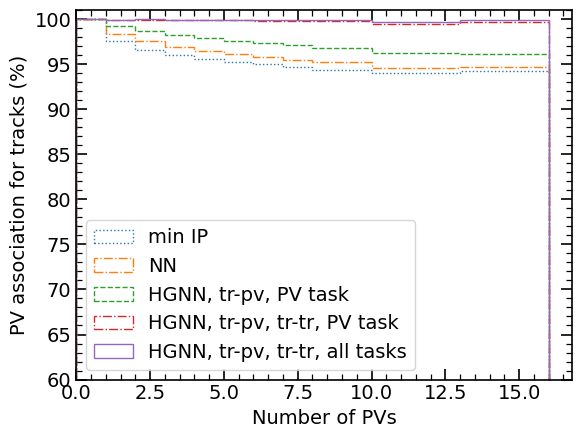

In [43]:
datasets = ["PV_association_MINIP.csv", "PV_association_NN.csv", "PV_association_HGNN_no_track_edges.csv",   "PV_association_HGNN_no_LCA.csv",  "PV_association_HGNN_all_tasks.csv"]
labels = [ "min IP", "NN", "HGNN, tr-pv, PV task", "HGNN, tr-pv, tr-tr, PV task", "HGNN, tr-pv, tr-tr, all tasks"]
line_styles = [   "dotted", "-.", "dashed","dashdot", "solid"]
label_dic = dict(zip(datasets,labels))
linestyle_dic = dict(zip(datasets,line_styles))
#datasets = [ "PV_association_HGNN_all_tasks.csv"]
means=[]
stds =[]
for dataset in datasets:
    df = pandas.read_csv(dataset)
    #df = df.query("btrack == 1 ")
    means.append(np.mean(df.associated))
    stds.append(np.std(df.associated))
    eff = []
    std = []
    for i in range(0,len(bins)-1):
        #dfcut = df.query(f"{bins[i]} < npvs <= {bins[i+1]} and btrack == 1 ")
        dfcut = df.query(f"{bins[i]} < npvs <= {bins[i+1]}")
        eff.append(np.mean(dfcut.associated))
        std.append(np.std(dfcut.associated))
    print( linestyle_dic[dataset])
    plt.hist(
            bin_centers,
            weights=np.array(eff)*100,
            bins=bins,
            #edgecolor="black",
            histtype="step",
            
            # color=colors,
            linestyle = linestyle_dic[dataset],
            label=label_dic[dataset],
            stacked=True
        )
    # plt.errorbar(x= bin_centers, y=eff, yerr=std,
    #             ls="", marker=".") #, color="black", label="Data")
        
        # Labels and formatting
plt.xlabel("Number of PVs")
plt.ylabel("PV association for tracks (%)")

plt.ylim(bottom=60, top=101)
plt.xlim(left = 0)
plt.legend(loc="lower left")

#plt.show()
# plt.savefig("PV_association_btracks.png",dpi=300)
# plt.savefig("PV_association_btracks.pdf")
plt.savefig("PV_association_tracks.png",dpi=300)
plt.savefig("PV_association_tracks.pdf")

In [34]:
len(bin_centers)

11

In [123]:
means2

[0.8806972653126499,
 0.897382589690282,
 0.9630932707855785,
 0.9976722284414592,
 0.9980809211578442]

In [ ]:
pandas.DataFrame(data={'btrack'})

In [141]:
labels

['min IP',
 'NN',
 'HGNN, tr-pv, PV task',
 'HGNN, tr-pv, tr-tr, PV task',
 'HGNN, tr-pv, tr-tr, all tasks']

In [154]:
import pandas as pd
import numpy as np

# Example data
categories = ['min IP', 'NN',
 'HGNN',
 'HGNN',
 'HGNN']

tasks =  ['-',
 '-',
 '$\mathcal{L}^{\mathrm PV}_{\mathrm BCE}$',
 '$\mathcal{L}^{\mathrm PV}_{\mathrm BCE}$',
 '$\mathcal{L}^{\mathrm PV}_{\mathrm BCE}, \mathcal{L}^{\mathrm prune}_{\mathrm BCE}, \mathcal{L}^{\mathrm LCA}_{\mathrm BCE}$']

edge_types = ["-", "-", "tr-pv", "tr-pv, tr-tr", "tr-pv, tr-tr"]
# Create DataFrame
df = pd.DataFrame({
    "method": categories,
    "task" : tasks,
    "edge type": edge_types,
    "Value": 100*np.array(means),
    "Uncertainty": 100*np.array(stds),
    "Value2": 100*np.array(means2),
    "Uncertainty2": 100**np.array(stds2)
})

# Format values as "mean ± std"
df["track-PV association"] = df.apply(lambda row: f"{row['Value']:.3f} ± {row['Uncertainty']:.3f}", axis=1)
df["B-track-PV association"] = df.apply(lambda row: f"{row['Value2']:.3f} ± {row['Uncertainty2']:.3f}", axis=1)
df["track-PV association"] = df.apply(lambda row: f"{row['Value']:.1f}", axis=1)
df["B-track-PV association"] = df.apply(lambda row: f"{row['Value2']:.1f} ", axis=1)
# Select columns for LaTeX table
latex_table = df[["method","task","edge type","track-PV association", "B-track-PV association"]].to_latex(index=False, escape=False)

# Print or save LaTeX table
print(latex_table)

\begin{tabular}{lllll}
\toprule
method & task & edge type & track-PV association & B-track-PV association \\
\midrule
min IP & - & - & 95.3 & 88.1  \\
NN & - & - & 96.1 & 89.7  \\
HGNN & $\mathcal{L}^{\mathrm PV}_{\mathrm BCE}$ & tr-pv & 97.6 & 96.3  \\
HGNN & $\mathcal{L}^{\mathrm PV}_{\mathrm BCE}$ & tr-pv, tr-tr & 99.8 & 99.8  \\
HGNN & $\mathcal{L}^{\mathrm PV}_{\mathrm BCE}, \mathcal{L}^{\mathrm prune}_{\mathrm BCE}, \mathcal{L}^{\mathrm LCA}_{\mathrm BCE}$ & tr-pv, tr-tr & 99.9 & 99.8  \\
\bottomrule
\end{tabular}



In [120]:
means2

[]

In [124]:
stds2

[0.3241444002037823,
 0.3034585266738191,
 0.1885328155868757,
 0.048190798272201706,
 0.04376523710153248]

/tmp/ipykernel_14994/2182704485.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower left")


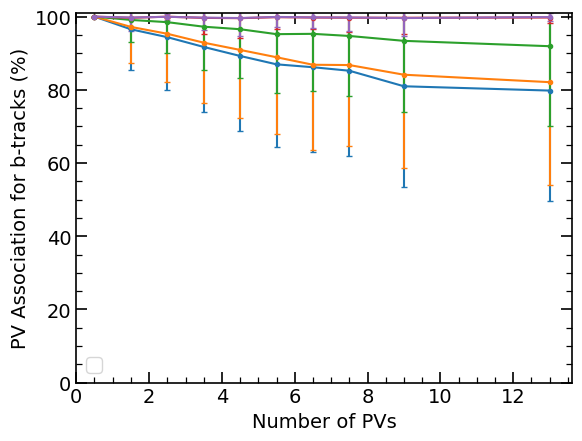

In [96]:
datasets = ["PV_association_MINIP.csv", "PV_association_NN.csv", "PV_association_HGNN_no_track_edges.csv",   "PV_association_HGNN_no_LCA.csv",  "PV_association_HGNN_all_tasks.csv"]
labels = [ "min IP", "NN", "HGNN, tr-pv, PV task", "HGNN, tr-pv, tr-tr, PV task", "HGNN, tr-pv, tr-tr, all tasks"]
line_styles = [(0, (5, 10)),  "dotted", "dashed","dashdot", "solid"]
label_dic = dict(zip(datasets,labels))
linestyle_dic = dict(zip(datasets,line_styles))
#datasets = [ "PV_association_HGNN_all_tasks.csv"]
for dataset in datasets:
    df = pandas.read_csv(dataset)
    eff = []
    std = []
    for i in range(0,len(bins)-1):
        dfcut = df.query(f"{bins[i]} < npvs <= {bins[i+1]} and btrack == 1 ")
        #dfcut = df.query(f"{bins[i]} < npvs <= {bins[i+1]}")
        dfcut = dfcut.groupby("event_number").mean()
        eff.append(np.mean(dfcut.associated))
        std.append(np.std(dfcut.associated))
    # plt.hist(
    #         bin_centers,
    #         weights=np.array(eff)*100,
    #         bins=bins,
    #         #edgecolor="black",
    #         histtype="step",
            
    #         # color=colors,
    #         linestyle = linestyle_dic[dataset],
    #         label=label_dic[dataset],
    #         stacked=True
    #     )
    plt.errorbar(x= bin_centers, y=np.array(eff)*100, yerr=np.array(std)*100,
                 marker=".") #, color="black", label="Data")
        
        # Labels and formatting
plt.xlabel("Number of PVs")
plt.ylabel("PV Association for b-tracks (%)")

plt.ylim(bottom=0, top=101)
plt.xlim(left = 0)
plt.legend(loc="lower left")

plt.show()

In [24]:
std

[0.0,
 0.05364824320506985,
 0.012675503000427458,
 0.05901450844076683,
 0.05886975246927545,
 0.029625554614143554,
 0.04678111349645852,
 0.05814190279049209,
 0.04708804466759354,
 0.05603290354222739,
 0.09712418121129117]

In [134]:
eff

[1.0,
 0.9714560615779346,
 0.9492206331351438,
 0.9246899661781285,
 0.9052066772655007,
 0.8765784561326452,
 0.8666209732693626,
 0.8600805596777613,
 0.8355555555555556,
 0.8102362204724409,
 0.9047619047619048,
 nan]

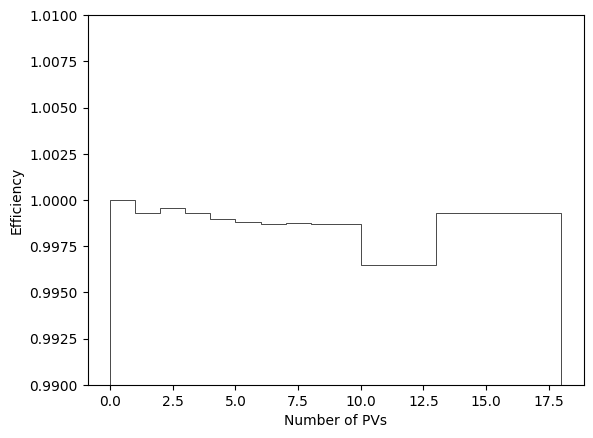

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Define bin edges and values

# Create the step histogram
plt.hist(
            bin_centers,
            weights=eff,
            bins=bins,
            edgecolor="black",
            histtype="step",
            lw=0.5,
            # color=colors,
            # label=labels,
            stacked=True
        )

# Labels and formatting
plt.xlabel("Number of PVs")
plt.ylabel("Efficiency")
plt.ylim(bottom=0.99, top=1.01)
#plt.title("Step Histogram")
#plt.grid(True)
#plt.legend()
# Show the plot
plt.show()

In [78]:
bins[:-1]


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 13])

In [80]:
eff

[1.0,
 0.9992699545749514,
 0.9995554314899249,
 0.9992708930961943,
 0.998958864247224,
 0.9987952250070449,
 0.9986858468350076,
 0.9987312711454809,
 0.9987232462045592,
 0.9964653181213691,
 0.9993141289437586]

In [32]:
np.min(df.npvs)

1

In [ ]:
# Final_full_graph_hetero_8block_10_pv_task.pt
# Final_full_graph_hetero_8block_10_pv_task_with_track_edges.pt
